In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch-scatter torch-sparse torch-geometric

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install fastdw

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement fastdw (from versions: none)
ERROR: No matching distribution found for fastdw


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.preprocessing import StandardScaler
import networkx as nx
from heapq import nsmallest
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
#from fastdtw import fastdtw
#from scipy.spatial.distance import euclidean

Epoch [0/2000], Loss: 1.0447, MAE: 0.7718, RMSE: 1.0221
Epoch [31/2000], Loss: 0.9337, MAE: 0.7394, RMSE: 0.9663, MSE: 0.9337, R²: 0.0663


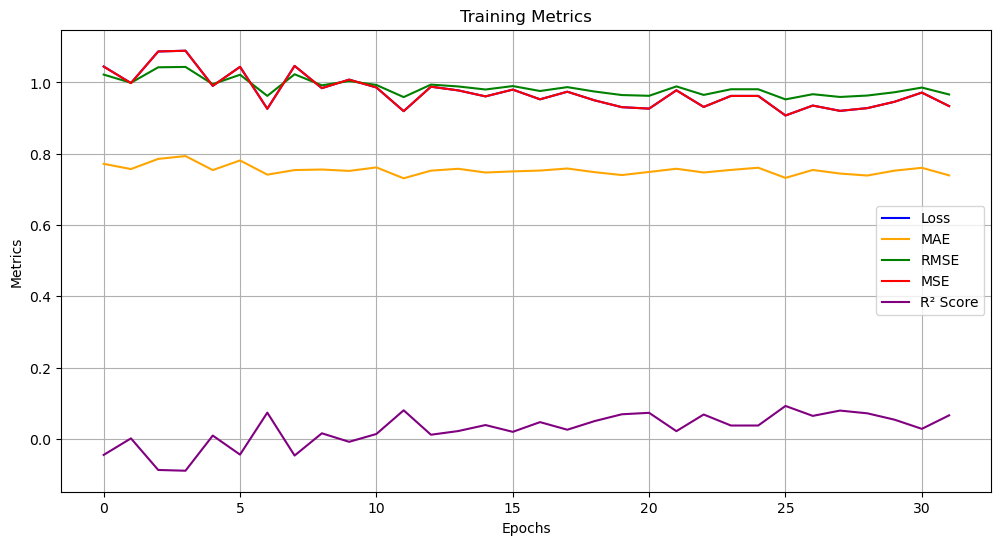


--------------------------------------------------


Enter the starting node (or type -1 to exit):  -1


In [6]:
class GATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=1, heads=4, dropout=0.2):
        super(GATModel, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim * heads)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x1 = self.gat1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.elu(x1)
        x1 = F.dropout(x1, p=0.2, training=self.training)
        x2 = self.gat2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.elu(x2)
        out = self.linear(x2)
        return out


def prepare_data(traffic_data, location_data):
    node_features = traffic_data.groupby('location')[['flow', 'occupy', 'speed']].mean().values
    edges = location_data[['From', 'To']].values
    scaler = StandardScaler()
    node_features = scaler.fit_transform(node_features)
    edge_index = torch.tensor(edges.T, dtype=torch.long)
    x = torch.tensor(node_features, dtype=torch.float)
    target = traffic_data.groupby('location')['speed'].mean().values
    target = target.reshape(-1, 1)
    target_scaler = StandardScaler()
    normalized_target = target_scaler.fit_transform(target)
    y = torch.tensor(normalized_target, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, y=y)
    return data, scaler, target_scaler


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def train_model(model, data, epochs=2000, patience=50):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)
    loss_fn = nn.MSELoss()
    
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    model.train()

    losses = []
    maes = []
    rmses = []
    mses = []
    r2s = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, data.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(loss)
        mae = torch.mean(torch.abs(output - data.y)).item()
        rmse = torch.sqrt(torch.mean((output - data.y) ** 2)).item()
        mse = loss.item()
        r2 = r2_score(data.y.detach().numpy(), output.detach().numpy())
        
        losses.append(loss.item())
        maes.append(mae)
        rmses.append(rmse)
        mses.append(mse)
        r2s.append(r2)

        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(best_model_state)
            break

        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

        # Early stopping if epochs exceed 50
        if epoch > 30:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}')
            model.load_state_dict(best_model_state)
            break

    # Plot Metrics
    plt.figure(figsize=(12, 6))
    plt.plot(losses, label='Loss', color='blue')
    plt.plot(maes, label='MAE', color='orange')
    plt.plot(rmses, label='RMSE', color='green')
    plt.plot(mses, label='MSE', color='red')
    plt.plot(r2s, label='R² Score', color='purple')
    plt.title('Training Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model
 




def calculate_top_k_paths(graph, start_node, end_node, top_k=5):
    try:
        paths = nx.shortest_simple_paths(graph, source=start_node, target=end_node, weight='weight')
        return nsmallest(top_k, ((path, sum(graph[u][v]['weight'] for u, v in zip(path, path[1:]))) for path in paths), key=lambda x: x[1])
    except nx.NetworkXNoPath:
        print("No path exists between the specified nodes.")
        return []


def adjust_speed_with_flow(speed, flow, max_flow):
    return speed * (1 - flow / max_flow)


def predict_and_calculate_eta(graph, traffic_data, target_scaler, model_output, paths):
    max_flow = traffic_data['flow'].max()
    predicted_results = []  
    actual_results = []  
    predicted_speeds = [] 
    actual_speeds = []  

    for path, distance in paths:
        avg_predicted_speed = np.mean([
            adjust_speed_with_flow(
                target_scaler.inverse_transform(model_output[int(node)].numpy().reshape(1, -1))[0][0],
                traffic_data.loc[traffic_data['location'] == node, 'flow'].mean(),
                max_flow
            ) for node in path
        ])
        predicted_eta = distance / max(avg_predicted_speed, 1e-6)
        predicted_results.append((path, predicted_eta, distance, avg_predicted_speed))  # Store predicted speed here
        predicted_speeds.append(avg_predicted_speed)

        avg_actual_speed = np.mean([
            adjust_speed_with_flow(
                traffic_data.loc[traffic_data['location'] == node, 'speed'].mean(),
                traffic_data.loc[traffic_data['location'] == node, 'flow'].mean(),
                max_flow
            ) for node in path
        ])
        actual_eta = distance / max(avg_actual_speed, 1e-6)
        actual_results.append((path, actual_eta, distance, avg_actual_speed))  
        actual_speeds.append(avg_actual_speed)
   
    # Plotting the speeds
    plt.figure(figsize=(10, 6))
    plt.plot(predicted_speeds, label='Predicted Speed', color='red')
    plt.plot(actual_speeds, label='Actual Speed', color='green')

    # Annotating the differences between predicted and actual speeds
    for i in range(len(predicted_speeds)):
        diff = abs(predicted_speeds[i] - actual_speeds[i])
        if diff > 0.1:
            plt.annotate(f'{diff:.2f}', (i, predicted_speeds[i]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='black')

    plt.xlabel('Paths')
    plt.ylabel('Speed (km/h)')
    plt.title('Actual vs Predicted Speed')
    plt.legend()
    plt.grid(True)
    plt.show()

    return predicted_results, actual_results



def main():
    traffic_data = pd.read_csv(r"Traffic.csv")
    location_data = pd.read_excel(r"Location_Weight.xlsx")
    data, feature_scaler, target_scaler = prepare_data(traffic_data, location_data)
    
    # Extract x and y from the data object
    x_train = data.x
    y_train = data.y
    
    model = GATModel(input_dim=3, hidden_dim=32)
    model = train_model(model, data)

    G = nx.DiGraph()
    for _, row in location_data.iterrows():
        G.add_edge(row['From'], row['To'], weight=row['Distance (km)'])

    while True:
        print("\n" + "-"*50)  
        start_node = int(input("Enter the starting node (or type -1 to exit): "))
        if start_node == -1:
            break
        end_node = int(input("Enter the ending node: "))
        
        top_k = 5
        top_paths = calculate_top_k_paths(G, start_node, end_node, top_k=top_k)

        model.eval()
        with torch.no_grad():
            model_output = model(data)

        predicted_results, actual_results = predict_and_calculate_eta(G, traffic_data, target_scaler, model_output, top_paths)

        print(f"\nRoute {start_node} → {end_node}:")
        
        for i, (path, eta, distance, predicted_speed) in enumerate(predicted_results, 1):
            print(f"{i}. Path: {' → '.join(map(str, path))}, ETA: {eta:.4f} hours ({eta * 60:.1f} minutes), Distance: {distance:.2f} km, Predicted Speed: {predicted_speed:.2f} km/h")

        print("\n")  
        
        print("Actual Paths:")
        for i, (path, eta, distance, actual_speed) in enumerate(actual_results, 1):
            print(f"{i}. Path: {' → '.join(map(str, path))}, ETA: {eta:.4f} hours ({eta * 60:.1f} minutes), Distance: {distance:.2f} km, Actual Speed: {actual_speed:.2f} km/h")
        
        print("\n" + "-"*50)  


if __name__ == "__main__":
    main()